In [147]:
import pandas as pd 
import numpy as np 
import pathlib as path
import matplotlib.pyplot as plt
import random
from PIL import Image
from random import sample

In [148]:
#this is where all downladed data exists (after extracting the zip file)
#PATH_TO_DATA = path.Path(r'C:\Users\User\Desktop\visualpilot')

PATH_TO_DATA = path.Path.cwd().parent / 'data' / 'pilot_same_day'  #true relational path

#this will define the name of the location to save the processed csv files (note that it will also create a "batch" directory)
batch_name='batch1' #defines the name of the current subfolder to work on

processed_name='processed data' + batch_name[-1]
PATH_TO_PROCESSED = PATH_TO_DATA / processed_name

if not(PATH_TO_PROCESSED.exists()):
    print('creating a new processed folder:',PATH_TO_PROCESSED)
    PATH_TO_PROCESSED.mkdir()
else:
    print('allready exists:',PATH_TO_PROCESSED)


allready exists: c:\Users\d_abe\Desktop\human similarity database\edens github repo\Visual-memory-task\data\pilot_same_day\processed data1


In [149]:
PATH_TO_BATCH=PATH_TO_DATA / batch_name
AMAZON_WORKER_fILE_PATH= PATH_TO_DATA / path.Path(batch_name+'_batch_results.csv')

batch_workers_df=pd.read_csv(AMAZON_WORKER_fILE_PATH)
print('number of amazon workers as reported from the amazon workers file : ',len(batch_workers_df))

#check how many participants are in the downloaded folder: 
participants_list_csvs=[file.name for file in PATH_TO_BATCH.iterdir() if '.csv' in file.name and file.stat().st_size>10000]
participants_list_names=[file.split('_')[0] for file in participants_list_csvs]
print(f'number of participant files (of sufficient size) in the downloaded results batch: {len(participants_list_csvs)}')
print(f'number of unique participant names in the batch: {len(set(participants_list_names))}')
#solve the non unique participants:
non_unique_names=np.unique([name for name in participants_list_names if participants_list_names.count(name)>1])

if len(non_unique_names)>0:
   print(f'\nhandling duplicate participants {len(non_unique_names)}:')
   #find the most recent/biggest file size from each non unique participant: 
   for participant in non_unique_names:
      all_curr_participant_csv_names=list(np.array(participants_list_csvs)[np.where(np.array(participants_list_names)==participant)])
      #get the system info on each of these duplicate files: 
      filesizes=[(PATH_TO_BATCH / file).stat().st_size for file in all_curr_participant_csv_names]
      filedates=[(PATH_TO_BATCH / file).stat().st_ctime for file in all_curr_participant_csv_names]
      largest_filesize_ind=np.argmax(filesizes) #get the index of the largest file from the duplicates
      latest_filedate_ind=np.argmax(filedates)  #get the index of the latest file from the duplicates
      if largest_filesize_ind==latest_filedate_ind: #if the same size is the most recent and largest use it as the participant file: 
         print(f'{participant} has {len(all_curr_participant_csv_names)} duplicate files  - taking the largest and latest file for this participant')
         valid_csv=all_curr_participant_csv_names[largest_filesize_ind]
         #remove it from the current subject duplicates list: 
         all_curr_participant_csv_names.remove(valid_csv)
         #remove the other duplicates fromt he participanst_list_csv: 
         for csv_to_remove in all_curr_participant_csv_names:
            participants_list_csvs.remove(csv_to_remove)
      else:
         print(f'{participant} has {len(all_curr_participant_csv_names)} duplicate files  the largest file is not the latest, so need to resolve this conflict manualy')

#get the aligned names vector after removing the duplicates: 
participants_list_names=[file.split('_')[0] for file in participants_list_csvs]
print(f'\nafter removing duplicate files, number of valid participant files = {len(participants_list_names)}\n')


#make sure the participants reported in the amazon workers corresponds to the valid csv files we got: 
print('going over the workers list as reported in amazon and finding a valid csv file for each')
valid_participants_files=[]
valid_participants_names=[]
for cur_participant in batch_workers_df['WorkerId'].values:
    if cur_participant in participants_list_names: 
      #update the batch workers file with the relevant csv name and validation columns
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'csv_path']=participants_list_csvs[participants_list_names.index(cur_participant)]
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'Approve']='x'
      #print(cur_participant)'
      valid_participants_files.append(participants_list_csvs[participants_list_names.index(cur_participant)]) 
      valid_participants_names.append(cur_participant)
    else:
      print('invalid',cur_participant)
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'Reject']='no results file was found on pavlovia servers'
    
print(f'number of valid participants to go to further processing is: {len(valid_participants_files)}')     
    

number of amazon workers as reported from the amazon workers file :  30
number of participant files (of sufficient size) in the downloaded results batch: 31
number of unique participant names in the batch: 30

handling duplicate participants 1:
A2JLNOYPVW7W4V has 2 duplicate files  the largest file is not the latest, so need to resolve this conflict manualy

after removing duplicate files, number of valid participant files = 31

going over the workers list as reported in amazon and finding a valid csv file for each
invalid A3D4ZHM3ABM5Z3
number of valid participants to go to further processing is: 29


In [150]:
batch_workers_df[['WorkerId','Approve','Reject','Answer.surveycode','csv_path']] #will add more columns with more information on disqualfication so we can decide if we pay or not

,WorkerId,Approve,Reject,Answer.surveycode,csv_path
0,A3SSIUMI7ONK5W,x,NaN,tjs,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv
1,A3D4ZHM3ABM5Z3,NaN,no results file was found on pavlovia servers,A3D4ZHM3ABM5Z3,NaN
2,A2NVX39CZ34V4E,x,NaN,tjs,A2NVX39CZ34V4E_2022-09-18_09h34.12.895.csv
3,A28OD52SMLYQ16,x,NaN,tjs,A28OD52SMLYQ16_2022-09-18_09h47.12.518.csv
4,A344BXT88DM2ZH,x,NaN,'tjs',A344BXT88DM2ZH_2022-09-18_09h11.14.066.csv
5,A2MIFJZZPOCI6,x,NaN,tjs,A2MIFJZZPOCI6_2022-09-18_07h49.50.603.csv
6,A3N5E6HZDBRFNC,x,NaN,tjs,A3N5E6HZDBRFNC_2022-09-18_14h35.20.436.csv
7,A287I4G1Q0K003,x,NaN,'tjs',A287I4G1Q0K003_2022-09-18_09h12.09.018.csv
8,A1YGV1J2URRQDG,x,NaN,'tjs',A1YGV1J2URRQDG_2022-09-18_09h23.56.570.csv
9,A1AW4WCRVLE1C6,x,NaN,'tjs',A1AW4WCRVLE1C6_2022-09-18_09h11.45.436.csv


In [151]:
def find_largest_consequtive_repetition(responses_array):
#add a stop value so the loop will use the logic also if the end of the responses is all repeating: 
    responses_array=np.append(responses_array,[99])
    longest_rep_dict=dict()
    last_input=responses_array[0]
    consequtive_rep_counter=0
    for response in responses_array[1:]: 
        if response==last_input: #if consequtive rep: 
            consequtive_rep_counter=consequtive_rep_counter+1 #add to counter
        else: #once a new entry is in the vector - store the counter rep information 
            if last_input in longest_rep_dict.keys(): #if it was allready stored in our dictionary
                if longest_rep_dict[last_input]<consequtive_rep_counter: #replace the counter only if it is higher than what stored in dict
                    longest_rep_dict[last_input]=consequtive_rep_counter
            else: #this entry is not yet in the dictionary: add it 
                longest_rep_dict[last_input]=consequtive_rep_counter
            
            consequtive_rep_counter=0
            last_input=response
    return max(longest_rep_dict.values())

In [152]:
def process_worker_results(PATH_TO_BATCH,subject_name):
    cur_sub=pd.read_csv(PATH_TO_BATCH / subject_name)
    sub_demographics=cur_sub[['workID','Age','Gender']].iloc[0]

    #extract demo related information: 

    #if participant did not click on the arrow during the demo a 'demo_encoding_response.rt' colmumn wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    if not('demo_encoding_response.rt' in cur_sub.columns):
        cur_sub['demo_encoding_response.rt']=np.nan
    demo_columns=['demo_encoding_loop.thisTrialN','DemoImage','DemoCorrect','demo_encoding_response.rt','demo_encoding_response.keys']

    sub_demo_information=cur_sub[demo_columns]
    empty_inds=sub_demo_information.loc[sub_demo_information.isnull().apply(lambda x: all(x), axis=1)].index
    #drop irrelevant columns: 
    sub_demo_information=sub_demo_information.drop(index=empty_inds)


    #extract the demo test columns: 
    demo_test_columns=['demo_test_response.keys','demo_test_response.corr','demo_test_response.rt','demo_test_loop.thisTrialN','DemoImage1','DemoImage2','DemoCorrectTest']
    sub_demo_test_information=cur_sub[demo_test_columns]
    empty_inds=sub_demo_test_information.loc[sub_demo_test_information.isnull().apply(lambda x: all(x), axis=1)].index
    #drop irrelevant columns: 
    sub_demo_test_information=sub_demo_test_information.drop(index=empty_inds)

    demo_df=pd.concat([sub_demo_information.reset_index(),sub_demo_test_information.reset_index()],axis=1)

    #extract real experiment related information: 

    #if participant did not click on the arrow during the encoding a 'test_encoding_response.rt' column wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    if not('test_encoding_response.rt' in cur_sub.columns):
        cur_sub['test_encoding_response.rt']=np.nan


    encoding_related_columns=['test_encoding_response.keys','test_encoding_response.corr','trials.thisTrialN','target_image','pair','layer','correct','test_encoding_response.rt','key_resp_end.keys']
    sub_encoding_information=cur_sub[encoding_related_columns]
    #encoding section ends with a key press of the space key: so seperate this phase by finding this space key row
    end_of_section_ind=np.where(sub_encoding_information['key_resp_end.keys']=='space')[0][0]
    sub_encoding_information=sub_encoding_information.iloc[0:end_of_section_ind]
    #remove all the rows that precede the real encoding phase: 
    empty_inds=sub_encoding_information.loc[sub_encoding_information.isnull().apply(lambda x: all(x), axis=1)].index
    sub_encoding_information=sub_encoding_information.drop(index=empty_inds).reset_index()

    #extract real experiment TEST related information: 
    test_related_columns=['layer','correct','test_test_response.keys','test_test_response.corr','test_test_response.rt','trials_2.thisRepN','trials_2.thisTrialN','trials_2.thisN','trials_2.thisIndex','trials_2.ran','image1','image2']
    sub_test_information=cur_sub[test_related_columns].iloc[end_of_section_ind+2:-1]


    subject_dictionary=dict()
    subject_dictionary['demographics']=sub_demographics
    subject_dictionary['demo_df']=demo_df
    subject_dictionary['encoding_df']=sub_encoding_information
    subject_dictionary['test_df']=sub_test_information

    return subject_dictionary



In [153]:
all_subjects_demo_df=pd.DataFrame()
all_subjects_encoding_df=pd.DataFrame()
all_subjects_test_df=pd.DataFrame()
all_subjects_biographics_df=pd.DataFrame()

for subject_name in valid_participants_files:
    print(subject_name)
    curr_subject_dictionary=process_worker_results(PATH_TO_BATCH,subject_name)
    curr_demo_df=curr_subject_dictionary['demo_df']
    curr_demo_df['subject']=subject_name
    curr_test_df=curr_subject_dictionary['test_df']
    curr_test_df['subject']=subject_name
    curr_encoding_df=curr_subject_dictionary['encoding_df']
    curr_encoding_df['subject']=subject_name
    curr_demographics_df=curr_subject_dictionary['demographics']
    curr_demographics_df['subject']=subject_name

    all_subjects_demo_df=pd.concat([all_subjects_demo_df,curr_demo_df],axis=0,ignore_index=True)
    all_subjects_encoding_df=pd.concat([all_subjects_encoding_df,curr_encoding_df],axis=0,ignore_index=True)
    all_subjects_test_df=pd.concat([all_subjects_test_df,curr_test_df],axis=0,ignore_index=True)
    all_subjects_biographics_df=pd.concat([all_subjects_biographics_df,pd.DataFrame(curr_demographics_df).T],axis=0,ignore_index=True)


all_subjects_demo_df.to_csv(PATH_TO_PROCESSED / 'all_subjects_demo_df.csv')
all_subjects_encoding_df.to_csv(PATH_TO_PROCESSED / 'all_subjects_encoding_df.csv')
all_subjects_test_df.to_csv(PATH_TO_PROCESSED / 'all_subjects_test_df.csv')
all_subjects_biographics_df.to_csv(PATH_TO_PROCESSED / 'all_subjects_biographics_df.csv')

A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv
A2NVX39CZ34V4E_2022-09-18_09h34.12.895.csv
A28OD52SMLYQ16_2022-09-18_09h47.12.518.csv
A344BXT88DM2ZH_2022-09-18_09h11.14.066.csv
A2MIFJZZPOCI6_2022-09-18_07h49.50.603.csv
A3N5E6HZDBRFNC_2022-09-18_14h35.20.436.csv
A287I4G1Q0K003_2022-09-18_09h12.09.018.csv
A1YGV1J2URRQDG_2022-09-18_09h23.56.570.csv
A1AW4WCRVLE1C6_2022-09-18_09h11.45.436.csv
A2Q0XPK1CBAKFA_2022-09-18_08h09.40.460.csv
A1NLJ1L4VCQYV2_2022-09-18_08h31.35.191.csv
A1PX4CR15QC57J_2022-09-18_14h21.23.163.csv
AS08ODODBG8BX_2022-09-18_09h19.30.174.csv
AK52RXEJKR81A_2022-09-18_09h09.49.419.csv
ALYR5CI2SM2JC_2022-09-18_08h16.05.906.csv
AZD5EFRI6AB7X_2022-09-18_09h13.34.352.csv
A1ZFTV403BYKYJ_2022-09-18_09h48.16.421.csv
AZ35WMIEU4RRK_2022-09-18_10h31.32.744.csv
AOOLS8280CL0Z_2022-09-18_10h26.55.173.csv
A289D98Z4GAZ28_2022-09-18_10h43.08.637.csv
A2LMSIDVE4E4IO_2022-09-18_09h13.43.452.csv
A2JLNOYPVW7W4V_2022-09-18_07h10.36.959.csv
A3QZPIABOH7AFM_2022-09-18_09h47.08.606.csv
A1J2KT39T9KW6S_202

In [154]:
from unicodedata import category

# if there are any empty values - fill with mean of subjects age 
mean_value = all_subjects_biographics_df['Age'].mean()
all_subjects_biographics_df['Age'].fillna(value=mean_value, inplace=True)
all_subjects_biographics_df['Age'] = all_subjects_biographics_df['Age'].astype(np.int64)

all_subjects_biographics_df['Age']=all_subjects_biographics_df['Age'].astype(int)
all_subjects_biographics_df['Gender'].replace({'woman':'female','FEMLAE':'female','Male':'male','MALE':'male','FEMALE':'female','Female':'female','ale':'male'},inplace=True)
if len(np.unique(all_subjects_biographics_df['Gender'].values))<=2:
    print('transformed the gender column to be consistent having two possible values:',np.unique(all_subjects_biographics_df['Gender'].values))
else: 
    print('gender is still inconsistent with more than 2 unique values:',np.unique(all_subjects_biographics_df['Gender'].values))
all_subjects_biographics_df['Gender']=all_subjects_biographics_df['Gender'].astype("category")

mean_age,min_age,max_age=all_subjects_biographics_df['Age'].mean(),all_subjects_biographics_df['Age'].min(),all_subjects_biographics_df['Age'].max()
female_prop=all_subjects_biographics_df.loc[all_subjects_biographics_df['Gender']=='female','Gender'].count()/all_subjects_biographics_df['Gender'].count()

print(f'Mean age: {mean_age:.2f}, range: [{min_age} - {max_age}], {female_prop:.2f}% female')


transformed the gender column to be consistent having two possible values: ['female' 'male']
Mean age: 39.41, range: [23 - 70], 0.52% female


# this part plots the seperate dataframes: 
### demo phase (encoding and test in the same dataframe)
### encoding experiment phase
### test experiment phase

In [155]:
all_subjects_demo_df.head(5)

,index,demo_encoding_loop.thisTrialN,DemoImage,DemoCorrect,demo_encoding_response.rt,demo_encoding_response.keys,index,demo_test_response.keys,demo_test_response.corr,demo_test_response.rt,demo_test_loop.thisTrialN,DemoImage1,DemoImage2,DemoCorrectTest,subject
0,4,0.0,flower1.jpg,NaN,NaN,NaN,12.0,right,0.0,4.4266,0.0,flower1.jpg,flower1_pair.jpg,left,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv
1,5,1.0,flower2.jpg,NaN,NaN,NaN,13.0,left,0.0,2.9932,1.0,flower2_pair.jpg,flower2.jpg,right,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv
2,6,2.0,left.jpg,left,NaN,NaN,14.0,left,1.0,1.5595,2.0,flower3.jpg,flower3_pair.jpg,left,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv
3,7,3.0,flower3.jpg,NaN,NaN,NaN,15.0,right,0.0,2.5024,3.0,flower4.jpg,flower4_pair.jpg,left,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv
4,8,4.0,flower4.jpg,NaN,NaN,NaN,16.0,right,1.0,2.1196,4.0,flower5_pair.jpg,flower5.jpg,right,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv


In [156]:
all_subjects_encoding_df.head(5)

,index,test_encoding_response.keys,test_encoding_response.corr,trials.thisTrialN,target_image,pair,layer,correct,test_encoding_response.rt,key_resp_end.keys,subject
0,20,NaN,1.0,0.0,2512875899-126682.jpg,2460547536-274179.jpg,1.0,NaN,NaN,NaN,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv
1,21,NaN,1.0,1.0,2964213381-294060.jpg,2458348012-349114.jpg,2.0,NaN,NaN,NaN,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv
2,22,NaN,1.0,2.0,2452381505-199546.jpg,2898632385-217138.jpg,2.0,NaN,NaN,NaN,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv
3,23,NaN,1.0,3.0,2874299429-139694.jpg,2883266367-365742.jpg,3.0,NaN,NaN,NaN,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv
4,24,NaN,1.0,4.0,2460547467-349422.jpg,2868487415-213924.jpg,2.0,NaN,NaN,NaN,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv


In [157]:
all_subjects_test_df.head(5)

,layer,correct,test_test_response.keys,test_test_response.corr,test_test_response.rt,trials_2.thisRepN,trials_2.thisTrialN,trials_2.thisN,trials_2.thisIndex,trials_2.ran,image1,image2,subject
0,1.0,right,right,1.0,3.7335,0.0,0.0,0.0,0.0,1.0,2864902304-137862.jpg,2864910426-287204.jpg,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv
1,1.0,left,left,1.0,1.4449,0.0,1.0,1.0,1.0,1.0,2868474407-362883.jpg,2460547732-349518.jpg,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv
2,1.0,left,left,1.0,2.4611,0.0,2.0,2.0,2.0,1.0,2238572663-35822.jpg,2238584894-113161.jpg,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv
3,1.0,left,right,0.0,1.6786,0.0,3.0,3.0,3.0,1.0,2898635427-367120.jpg,2964221435-219434.jpg,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv
4,1.0,right,left,0.0,1.5932,0.0,4.0,4.0,4.0,1.0,2579432519-130698.jpg,2981231403-71642.jpg,A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv


In [158]:
#this section extract information from the demo phase: it creates a df (all_subjects_summary_demo_info) containingsingle row per participants with metrics from the demo phase (average accuracy, RTs and so on (this can be used to screen participatns for further analysis)):
all_subjects_summary_demo_info=pd.DataFrame(index=list(all_subjects_demo_df['subject'].unique()))

for cur_subject in all_subjects_demo_df['subject'].unique():
    cur_sub_demo_encoding=all_subjects_demo_df.loc[all_subjects_demo_df['subject']==cur_subject]
    
    #get only attention check related info: 
    curr_subjects_summary_demo_info=cur_sub_demo_encoding[['demo_encoding_response.keys','DemoCorrect','demo_encoding_response.rt']].copy().dropna()
    if len(curr_subjects_summary_demo_info)==0: #empty - the participant didnt respond on the arrow at all: 
       all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=0 
       all_subjects_summary_demo_info.loc[cur_subject,'arrow_rt']=np.nan
    else: 
        all_subjects_summary_demo_info.loc[cur_subject,'arrow_rt']=curr_subjects_summary_demo_info['demo_encoding_response.rt'].values
        if all(curr_subjects_summary_demo_info['DemoCorrect']==curr_subjects_summary_demo_info['demo_encoding_response.keys']):
            all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=1
        else:
            all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=0


    #get the correctness of the demo testing phase: 
    cur_sub_demo_test_performence=cur_sub_demo_encoding[['DemoCorrectTest','demo_test_response.keys','demo_test_response.rt']].copy().dropna()
    test_match_df=pd.DataFrame(columns=['arrow_correct'],data=cur_sub_demo_test_performence['DemoCorrectTest']==cur_sub_demo_test_performence['demo_test_response.keys'])
    test_match_df['demo_test_response.rt']=cur_sub_demo_test_performence['demo_test_response.rt']
    accuracy=test_match_df['arrow_correct'].mean()
    mean_rt=test_match_df['demo_test_response.rt'].mean()
    correct_and_incorrect_rts=test_match_df.groupby('arrow_correct').aggregate({'demo_test_response.rt':'mean'})
    #update the summary info row: 
    all_subjects_summary_demo_info.loc[cur_subject,'demo_accuracy']=accuracy
    all_subjects_summary_demo_info.loc[cur_subject,'RT_overall_mean']=mean_rt
    all_subjects_summary_demo_info.loc[cur_subject,['RT_incorrect_mean','RT_correct_mean']]=np.nan

    if False in correct_and_incorrect_rts.index:
        all_subjects_summary_demo_info.loc[cur_subject,'RT_incorrect_mean']=correct_and_incorrect_rts.loc[False].values[0]
    if True in correct_and_incorrect_rts.index:
        all_subjects_summary_demo_info.loc[cur_subject,'RT_correct_mean']=correct_and_incorrect_rts.loc[True].values[0]


#add a prefix to column names: 
all_subjects_summary_demo_info.columns=['demo_'+col for col in all_subjects_summary_demo_info.columns]
all_subjects_summary_demo_info.head(5)

,demo_arrow_correct,demo_arrow_rt,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean
A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv,0.0,NaN,0.500000,2.395550,3.3074,1.483700
A2NVX39CZ34V4E_2022-09-18_09h34.12.895.csv,0.0,NaN,0.333333,185.596350,278.3189,0.151250
A28OD52SMLYQ16_2022-09-18_09h47.12.518.csv,1.0,0.3730,0.833333,3.287333,4.4740,3.050000
A344BXT88DM2ZH_2022-09-18_09h11.14.066.csv,0.0,2.3575,0.500000,2.584883,3.2033,1.966467
A2MIFJZZPOCI6_2022-09-18_07h49.50.603.csv,0.0,0.2098,0.500000,0.813833,0.3475,1.280167


In [159]:
#this part extract summary information from the experiment encoding phase: attention check accuracy and timings: 
all_subjects_summary_encoding_info=pd.DataFrame(index=list(all_subjects_encoding_df['subject'].unique()))

for cur_subject in all_subjects_encoding_df['subject'].unique():
    cur_sub_encoding=all_subjects_encoding_df.loc[all_subjects_encoding_df['subject']==cur_subject]
    
    #get only attention check related info: 
    cur_sub_encoding=cur_sub_encoding[['test_encoding_response.keys','correct','test_encoding_response.rt']].copy().dropna(how = 'all')
    if len(cur_sub_encoding)==0: #empty - the participant didnt respond on the arrow at all: 
       all_subjects_summary_encoding_info.loc[cur_subject,'arrow_accuracy']=0 
       all_subjects_summary_encoding_info.loc[cur_subject,'arrow_mean_rt']=np.nan
    else: 
        all_subjects_summary_encoding_info.loc[cur_subject,'arrow_mean_rt']=cur_sub_encoding['test_encoding_response.rt'].mean()
        arrow_accuracy=(cur_sub_encoding['correct']==cur_sub_encoding['test_encoding_response.keys']).mean()
        all_subjects_summary_encoding_info.loc[cur_subject,'arrow_accuracy']=arrow_accuracy



#add a prefix to column names: 
all_subjects_summary_encoding_info.columns=['encoding_'+col for col in all_subjects_summary_encoding_info.columns]        
all_subjects_summary_encoding_info.head(5)

,encoding_arrow_mean_rt,encoding_arrow_accuracy
A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv,1.633333,0.4
A2NVX39CZ34V4E_2022-09-18_09h34.12.895.csv,1.127340,1.0
A28OD52SMLYQ16_2022-09-18_09h47.12.518.csv,1.015600,1.0
A344BXT88DM2ZH_2022-09-18_09h11.14.066.csv,1.280650,0.6
A2MIFJZZPOCI6_2022-09-18_07h49.50.603.csv,1.799600,0.4


In [160]:
#this part extract summary information from the experiment testing phase: attention check accuracy and timings: 
all_subjects_summary_testing_info=pd.DataFrame(index=list(all_subjects_test_df['subject'].unique()))

for cur_subject in all_subjects_test_df['subject'].unique():
    cur_sub_testing=all_subjects_test_df.loc[all_subjects_test_df['subject']==cur_subject]

    #get the correctness of the testing phase: 
    cur_sub_testing_performence=cur_sub_testing[['correct','test_test_response.keys','test_test_response.rt','layer','test_test_response.corr']].copy().dropna()


    test_match_df=pd.DataFrame(columns=['correct'],data=cur_sub_testing_performence['correct']==cur_sub_testing_performence['test_test_response.keys'])
    test_match_df['test_test_response.rt']=cur_sub_testing_performence['test_test_response.rt']
    accuracy=test_match_df['correct'].mean()
    mean_rt=test_match_df['test_test_response.rt'].mean()
    correct_and_incorrect_rts_overall=test_match_df.groupby('correct').aggregate({'test_test_response.rt':'mean'})
    
    #update the summary info row: 
    all_subjects_summary_testing_info.loc[cur_subject,'Test_overall_accuracy']=accuracy
    all_subjects_summary_testing_info.loc[cur_subject,'RT_overall_mean']=mean_rt
    all_subjects_summary_testing_info.loc[cur_subject,['RT_incorrect_mean','RT_correct_mean']]=np.nan

    if False in correct_and_incorrect_rts_overall.index:
        all_subjects_summary_testing_info.loc[cur_subject,'RT_incorrect_mean']=correct_and_incorrect_rts_overall.loc[False].values[0]
    if True in correct_and_incorrect_rts_overall.index:
        all_subjects_summary_testing_info.loc[cur_subject,'RT_correct_mean']=correct_and_incorrect_rts_overall.loc[True].values[0]



    #extract layer wise information (accuracy and rt):
    correct_and_incorrect_rts=cur_sub_testing_performence.groupby('layer').aggregate({'test_test_response.rt':'mean','test_test_response.corr':'mean'})
    all_subjects_summary_testing_info.loc[cur_subject,['layer_1_rt','layer_1_accuracy','layer_2_rt','layer_2_accuracy','layer_3_rt','layer_3_accuracy']]=correct_and_incorrect_rts.values.flatten()


    #check the longest structured strike (to find bots or very unattentive participants):
    responses=cur_sub_testing_performence['test_test_response.keys'].replace({'left':1,'right':2}).values
    max_iter=find_largest_consequtive_repetition(responses)

    all_subjects_summary_testing_info.loc[cur_subject,'longest_response_strike']=max_iter

#add a prefix to column names: 
all_subjects_summary_testing_info.columns=['testing_'+col for col in all_subjects_summary_testing_info.columns]        
all_subjects_summary_testing_info.head()

,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv,0.60,1.201172,1.132625,1.246869,1.445760,0.60,1.077425,0.60,1.080330,0.60,2.0
A2NVX39CZ34V4E_2022-09-18_09h34.12.895.csv,0.60,0.863125,0.798171,0.906428,1.065455,0.60,0.597275,0.55,0.926645,0.65,6.0
A28OD52SMLYQ16_2022-09-18_09h47.12.518.csv,0.70,2.321117,2.195222,2.375071,2.222650,0.85,2.253200,0.70,2.487500,0.55,5.0
A344BXT88DM2ZH_2022-09-18_09h11.14.066.csv,0.65,1.751567,1.682971,1.788503,1.830525,0.70,1.712775,0.50,1.711400,0.75,5.0
A2MIFJZZPOCI6_2022-09-18_07h49.50.603.csv,0.90,5.812633,9.497017,5.403257,4.411285,0.95,5.066450,0.80,7.960165,0.95,2.0


In [161]:
def find_outlier_responses(sub_test_dataframe,fast_threshold=0.1,fast_allowed_count=2,slow_threshold=10,slow_allowed_count=2):
    isfast_outlier=(sub_test_dataframe['test_test_response.rt']<fast_threshold).sum()>fast_allowed_count
    isslow_outlier=(sub_test_dataframe['test_test_response.rt']>slow_threshold).sum()>slow_allowed_count
    return isfast_outlier,isslow_outlier

In [162]:
#combine all oneliners into a single matrix - 1 line per participant with all information we want:
data_df_for_analysis=pd.concat([all_subjects_summary_demo_info,all_subjects_summary_encoding_info,all_subjects_summary_testing_info],axis=1)
data_df_for_analysis


#define thresholds: 
demo_accuracy_treshold=0.5
demo_arrow_correctness=1
encoding_arrow_accuracy=0.6
longest_allowed_consequtive_strike=15
fast_threshold=0.3
fast_allowed_count=3
slow_threshold=10
slow_allowed_count=2


#how many participants would fail the demo (did not correctly answered the arrow or had less than 60% performence)
demo_criterions_accuracy=data_df_for_analysis['demo_demo_accuracy']>=demo_accuracy_treshold
demo_criterions_attention_check=data_df_for_analysis['demo_arrow_correct']>=demo_arrow_correctness
#find which participants performed pooly on the attention checks of the experiment encoding phase: 
encoding_ciriterions=data_df_for_analysis['encoding_arrow_accuracy']>encoding_arrow_accuracy
#remove participants that are too slow: 
test_criterions_strike=data_df_for_analysis['testing_longest_response_strike']<longest_allowed_consequtive_strike

too_fast_criterions=[]
too_slow_criterions=[]
for subject in data_df_for_analysis.index:
    sub_test_dataframe=all_subjects_test_df[all_subjects_test_df['subject']==subject]
    toofast_criterion,tooslow_criterion=find_outlier_responses(sub_test_dataframe,fast_threshold=fast_threshold,fast_allowed_count=fast_allowed_count,slow_threshold=slow_threshold,slow_allowed_count=slow_allowed_count)
    too_slow_criterions.append(not tooslow_criterion)
    too_fast_criterions.append(not toofast_criterion)


print(f'summary for criterions:')
print(f'demo accuracy higher than {demo_accuracy_treshold} - qualified: {demo_criterions_accuracy.sum()}')
print(f'demo attention check correctness equals {demo_arrow_correctness} - qualified: {demo_criterions_attention_check.sum()}')
print(f'experiment encoding attention check accuracy {encoding_arrow_accuracy} - qualified: {encoding_ciriterions.sum()}')
print(f'experiment longest consequtive strike of maximum of  {longest_allowed_consequtive_strike} responses - qualified: {test_criterions_strike.sum()}')
print(f'test too fast (thresold: {fast_threshold}, allowed count: {fast_allowed_count} qualified: {sum(too_fast_criterions)}')
print(f'test too slow (thresold: {slow_threshold}, allowed count: {slow_allowed_count} qualified: {sum(too_slow_criterions)}')


#accuracy criterion on the test: 
test_accuracy_critertions=(data_df_for_analysis['testing_Test_overall_accuracy']>=0.61) | (data_df_for_analysis[['testing_layer_1_accuracy' ,'testing_layer_2_accuracy' ,'testing_layer_3_accuracy']]>=0.75).T.any()
#remove participants that were discarded based on behavior up to the test and now qualify or disqualify based on test accuracy (do they have atleast 1 significant (binomial test) accuracy in one layer, or above threshold in overall accuracy )
only_qualified=demo_criterions_accuracy & demo_criterions_attention_check & encoding_ciriterions & test_criterions_strike & too_fast_criterions & too_slow_criterions & test_accuracy_critertions

print(f'OVERALL: number of qualified participants (adhere to all criterions): {sum(only_qualified)}')



summary for criterions:
demo accuracy higher than 0.5 - qualified: 23
demo attention check correctness equals 1 - qualified: 17
experiment encoding attention check accuracy 0.6 - qualified: 17
experiment longest consequtive strike of maximum of  15 responses - qualified: 27
test too fast (thresold: 0.3, allowed count: 3 qualified: 25
test too slow (thresold: 10, allowed count: 2 qualified: 27
OVERALL: number of qualified participants (adhere to all criterions): 11


In [163]:
data_df_for_analysis

,demo_arrow_correct,demo_arrow_rt,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv,0.0,NaN,0.500000,2.395550,3.307400,1.483700,1.633333,0.4,0.600000,1.201172,1.132625,1.246869,1.445760,0.600000,1.077425,0.60,1.080330,0.600000,2.0
A2NVX39CZ34V4E_2022-09-18_09h34.12.895.csv,0.0,NaN,0.333333,185.596350,278.318900,0.151250,1.127340,1.0,0.600000,0.863125,0.798171,0.906428,1.065455,0.600000,0.597275,0.55,0.926645,0.650000,6.0
A28OD52SMLYQ16_2022-09-18_09h47.12.518.csv,1.0,0.3730,0.833333,3.287333,4.474000,3.050000,1.015600,1.0,0.700000,2.321117,2.195222,2.375071,2.222650,0.850000,2.253200,0.70,2.487500,0.550000,5.0
A344BXT88DM2ZH_2022-09-18_09h11.14.066.csv,0.0,2.3575,0.500000,2.584883,3.203300,1.966467,1.280650,0.6,0.650000,1.751567,1.682971,1.788503,1.830525,0.700000,1.712775,0.50,1.711400,0.750000,5.0
A2MIFJZZPOCI6_2022-09-18_07h49.50.603.csv,0.0,0.2098,0.500000,0.813833,0.347500,1.280167,1.799600,0.4,0.900000,5.812633,9.497017,5.403257,4.411285,0.950000,5.066450,0.80,7.960165,0.950000,2.0
A3N5E6HZDBRFNC_2022-09-18_14h35.20.436.csv,1.0,1.1930,0.500000,2.429500,2.434667,2.424333,1.051600,1.0,0.650000,2.965683,3.126667,2.879000,3.431300,0.700000,2.767400,0.55,2.698350,0.700000,7.0
A287I4G1Q0K003_2022-09-18_09h12.09.018.csv,1.0,0.7924,0.333333,0.931750,0.806750,1.181750,NaN,0.0,0.633333,1.421333,1.322386,1.478618,1.831260,0.700000,1.147340,0.65,1.285400,0.550000,5.0
A1YGV1J2URRQDG_2022-09-18_09h23.56.570.csv,0.0,NaN,0.833333,3.887833,4.812000,3.703000,NaN,0.0,0.800000,2.243450,2.600167,2.154271,1.968450,0.750000,2.529850,0.80,2.232050,0.850000,10.0
A1AW4WCRVLE1C6_2022-09-18_09h11.45.436.csv,1.0,1.5786,0.666667,3.496850,4.653300,2.918625,1.129525,0.8,0.583333,2.323327,2.193892,2.415780,2.475250,0.700000,2.213210,0.55,2.281520,0.500000,3.0
A2Q0XPK1CBAKFA_2022-09-18_08h09.40.460.csv,0.0,NaN,0.666667,0.396550,0.015500,0.587075,0.418940,0.2,0.559322,0.037775,0.066615,0.015052,0.082310,0.600000,0.014890,0.45,0.014984,0.631579,22.0


In [164]:
#update the batch_workers_df  with columns representing disqualification reasons: 
tooslow_df=pd.DataFrame(data=too_slow_criterions,index=data_df_for_analysis.index,columns=['not_too_slow'])
toofast_df=pd.DataFrame(data=too_fast_criterions,index=data_df_for_analysis.index,columns=['not_too_Fast'])
test_accuracy_critertions=pd.DataFrame(data=test_accuracy_critertions,index=data_df_for_analysis.index, columns=['sufficient_test_acc'])
disqualification_df=pd.concat([demo_criterions_accuracy,demo_criterions_attention_check,encoding_ciriterions,test_criterions_strike,tooslow_df,toofast_df,test_accuracy_critertions],axis=1)
disqualification_df.head(5)


,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast,sufficient_test_acc
A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv,True,False,False,True,True,True,False
A2NVX39CZ34V4E_2022-09-18_09h34.12.895.csv,False,False,True,True,True,False,False
A28OD52SMLYQ16_2022-09-18_09h47.12.518.csv,True,True,True,True,True,True,True
A344BXT88DM2ZH_2022-09-18_09h11.14.066.csv,True,False,False,True,True,True,True
A2MIFJZZPOCI6_2022-09-18_07h49.50.603.csv,True,False,False,True,False,True,True


In [165]:
#merge workers_df with disqualification and save: 
index_list=[ind.split('_')[0] for ind in disqualification_df.index]
disqualification_df['WorkerId']=index_list
batch_workers_df_extended = batch_workers_df.merge(disqualification_df, on="WorkerId", how = 'inner')
batch_workers_df_extended = batch_workers_df.merge(disqualification_df, on="WorkerId", how = 'outer')

#add qualification column: (currently any participant will get this qualification (even if he just openneded the experiment and quit, because we dont want him back)
qualification_colname='UPDATE-completed memory rep'
batch_workers_df_extended[qualification_colname]=1

batch_workers_df_extended.to_csv(PATH_TO_DATA / path.Path(batch_name+'_batch_results_extended_with_disqualification.csv'))
batch_workers_df.to_csv(PATH_TO_DATA / path.Path(batch_name+'_batch_results_for_upload.csv'))


In [166]:
#extract data that passes all criterions: 
final_participants_df=data_df_for_analysis[only_qualified]

final_participants_df

,demo_arrow_correct,demo_arrow_rt,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A28OD52SMLYQ16_2022-09-18_09h47.12.518.csv,1.0,0.3730,0.833333,3.287333,4.474000,3.050000,1.015600,1.0,0.700000,2.321117,2.195222,2.375071,2.222650,0.85,2.253200,0.70,2.487500,0.55,5.0
A3N5E6HZDBRFNC_2022-09-18_14h35.20.436.csv,1.0,1.1930,0.500000,2.429500,2.434667,2.424333,1.051600,1.0,0.650000,2.965683,3.126667,2.879000,3.431300,0.70,2.767400,0.55,2.698350,0.70,7.0
A1NLJ1L4VCQYV2_2022-09-18_08h31.35.191.csv,1.0,0.5750,0.666667,1.774333,1.668000,1.827500,0.637600,1.0,0.816667,2.405467,2.601545,2.361449,2.290600,0.85,2.469400,0.85,2.456400,0.75,5.0
AS08ODODBG8BX_2022-09-18_09h19.30.174.csv,1.0,1.7030,0.666667,3.532133,4.662600,2.966900,1.606175,0.8,0.716667,2.250200,2.214976,2.264126,2.254395,0.75,2.270540,0.70,2.225665,0.70,4.0
AOOLS8280CL0Z_2022-09-18_10h26.55.173.csv,1.0,0.7346,0.833333,1.798917,1.499300,1.858840,0.574620,1.0,0.850000,1.975633,2.656678,1.855449,1.881890,0.90,1.978700,0.90,2.066310,0.75,4.0
A289D98Z4GAZ28_2022-09-18_10h43.08.637.csv,1.0,0.7496,0.833333,1.497067,1.631700,1.470140,0.662780,1.0,0.833333,1.429043,1.818430,1.351166,1.331215,0.90,1.518685,0.75,1.437230,0.85,4.0
A2LMSIDVE4E4IO_2022-09-18_09h13.43.452.csv,1.0,1.8633,0.500000,2.282500,1.647633,2.917367,1.907125,0.8,0.633333,1.693133,1.638932,1.724513,1.577505,0.65,1.638515,0.70,1.863380,0.55,3.0
A2JLNOYPVW7W4V_2022-09-18_07h10.36.959.csv,1.0,2.7373,0.666667,14.217767,4.466950,19.093175,2.315460,1.0,0.766667,3.569383,4.516357,3.281174,3.350005,0.80,3.286030,0.75,4.072115,0.75,5.0
A35SQDP3G7ZFEP_2022-09-18_09h09.49.234.csv,1.0,1.2288,0.500000,2.795750,2.631233,2.960267,1.724720,1.0,0.700000,2.175347,2.378172,2.088421,2.101685,0.80,2.069260,0.60,2.355095,0.70,3.0
A2YC6PEMIRSOAA_2022-09-18_08h22.21.342.csv,1.0,0.4552,0.833333,2.043567,1.657600,2.120760,0.986460,1.0,0.800000,1.799150,2.097575,1.724544,1.820635,0.75,1.965180,0.80,1.611635,0.85,8.0


In [167]:
total_data = pd.concat([data_df_for_analysis,disqualification_df], axis = 1)
total_data.head()

,demo_arrow_correct,demo_arrow_rt,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,...,testing_layer_3_accuracy,testing_longest_response_strike,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast,sufficient_test_acc,WorkerId
A3SSIUMI7ONK5W_2022-09-18_07h12.45.775.csv,0.0,NaN,0.500000,2.395550,3.3074,1.483700,1.633333,0.4,0.60,1.201172,...,0.60,2.0,True,False,False,True,True,True,False,A3SSIUMI7ONK5W
A2NVX39CZ34V4E_2022-09-18_09h34.12.895.csv,0.0,NaN,0.333333,185.596350,278.3189,0.151250,1.127340,1.0,0.60,0.863125,...,0.65,6.0,False,False,True,True,True,False,False,A2NVX39CZ34V4E
A28OD52SMLYQ16_2022-09-18_09h47.12.518.csv,1.0,0.3730,0.833333,3.287333,4.4740,3.050000,1.015600,1.0,0.70,2.321117,...,0.55,5.0,True,True,True,True,True,True,True,A28OD52SMLYQ16
A344BXT88DM2ZH_2022-09-18_09h11.14.066.csv,0.0,2.3575,0.500000,2.584883,3.2033,1.966467,1.280650,0.6,0.65,1.751567,...,0.75,5.0,True,False,False,True,True,True,True,A344BXT88DM2ZH
A2MIFJZZPOCI6_2022-09-18_07h49.50.603.csv,0.0,0.2098,0.500000,0.813833,0.3475,1.280167,1.799600,0.4,0.90,5.812633,...,0.95,2.0,True,False,False,True,False,True,True,A2MIFJZZPOCI6


In [168]:
#save the final_participants_df and the data_df_for_analysis to disk: 
final_participants_df.to_csv(PATH_TO_PROCESSED / 'one_line_per_participant_all_info_valid_subjects_only.csv')
total_data.to_csv(PATH_TO_PROCESSED / 'one_line_per_participant_all_info_all_subject.csv')

c:\Users\d_abe\.conda\envs\my_env_v3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\d_abe\.conda\envs\my_env_v3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


Text(365.48863636363626, 0.5, 'RT')

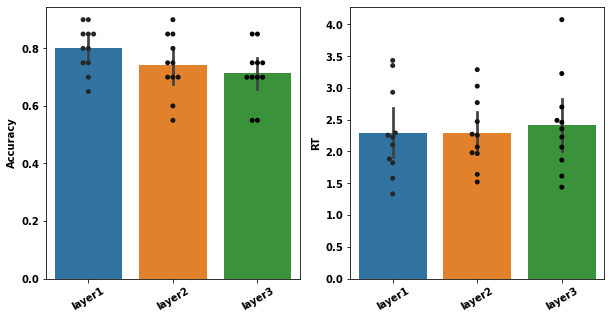

In [169]:
import seaborn as sns

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.barplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0])
sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')

sns.barplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1])
sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1],color='k')

axes[1].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[1].set_ylabel('RT')


Text(0, 0.5, 'RT')

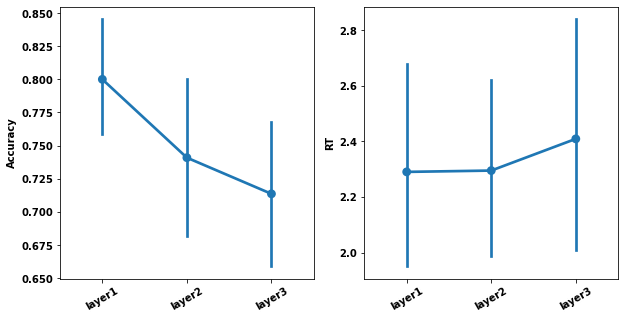

In [170]:
import seaborn as sns

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.pointplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')

sns.pointplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1],color='k')

axes[1].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[1].set_ylabel('RT')
